In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.071 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

try:
    plt.style.use("~/matplotlib.mplstyle")
except: raise

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return pd.DataFrame()
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

## Overlayed Histograms

In [6]:
gpteg = execute("""
    SELECT ed.value FROM extracted_data ed
    WHERE property = 'bandgap'
    AND method = 'GPT-3.5'
""")

gpttg = execute("""
    SELECT ed.value FROM extracted_data ed
    WHERE property = 'tg'
    AND method = 'GPT-3.5'
""")

mbteg = execute("""
    SELECT ed.value FROM extracted_data ed
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ed."method" = 'MaterialsBERT'
    AND ed.property = 'bandgap'
    AND EXISTS (
        SELECT fp.para_id FROM filtered_paragraphs fp 
        WHERE fp.filter_name LIKE '%_ner_full'
        AND fp.para_id = em.para_id
    );
""")

mbttg = execute("""
    SELECT ed.value FROM extracted_data ed
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ed."method" = 'MaterialsBERT'
    AND ed.property = 'tg'
    AND EXISTS (
        SELECT fp.para_id FROM filtered_paragraphs fp 
        WHERE fp.filter_name LIKE '%_ner_full'
        AND fp.para_id = em.para_id
    );
""")


In [7]:
absdata = pd.read_csv('data/Abstract-Extracted_Data.csv', index_col=0)
abstg = absdata[absdata['prop'] == 'glass transition temperature']
abseg = absdata[absdata['prop'] == 'bandgap']

In [8]:
abstg = abstg[(abstg.value >= -200) & (abstg.value <= 600)]
abseg = abseg[(abseg.value >= 0) & (abseg.value <= 7)]


In [9]:
print('Bandgap:')
print('\tgpt_total:', len(gpteg[(gpteg.value >= 0) & (gpteg.value <= 7)]))
print('\tmbt_total:', len(mbteg[(mbteg.value >= 0) & (mbteg.value <= 7)]))
print('\tabs_total:', len(abseg))

print('Tg:')
print('\tgpt_total:', len(gpttg[(gpttg.value >= -200) & (gpttg.value <= 600)]))
print('\tmbt_total:', len(mbttg[(mbttg.value >= -200) & (mbttg.value <= 600)]))
print('\tabs_total:', len(abstg))


Bandgap:
	gpt_total: 62883
	mbt_total: 24598
	abs_total: 2532
Tg:
	gpt_total: 124915
	mbt_total: 62178
	abs_total: 6898


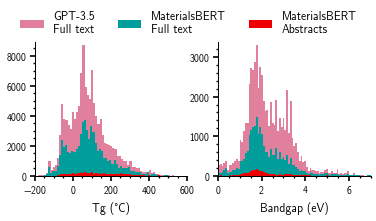

In [10]:
plt.rcParams['font.family'] = 'cursive'
plt.rcParams['axes.labelsize'] = 'medium'

n = 85

fig, ax = plt.subplots(1, 2, dpi=120, figsize=(3.25, 1.65))
ax[0].hist(gpttg.value, color='#e0809d', bins=n, label = 'GPT-3.5\nFull text')
ax[0].hist(mbttg.value, color='#009d9a', bins=n, label = 'MaterialsBERT\nFull text')
ax[0].hist(abstg.value, color='#ee0000', bins=n, label = 'MaterialsBERT\nAbstracts')
ax[0].set(xlabel='Tg (°C)', xlim=(-200, 600))

ax[1].hist(gpteg.value, color='#e0809d', bins=n, label = 'GPT-3.5')
ax[1].hist(mbteg.value, color='#009d9a', bins=n, label = 'MaterialsBERT')
ax[1].hist(abseg.value, color='#ee0000', bins=n, label = 'Abstracts')
ax[1].set(xlabel='Bandgap (eV)', xlim=(0, 7))

lines, labels = ax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=plt.gcf().transFigure, ncol=3)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('notebooks/Extracted-Data-Histograms.png', dpi=600)
plt.show()

## Most extracted data for paragraphs

In [6]:
most = execute("""
    SELECT
        em.para_id,
        sum(CASE WHEN ed."method" = 'GPT-3.5' 		THEN 1 ELSE 0 END) AS GPT,
        sum(CASE WHEN ed."method" = 'MaterialsBERT' THEN 1 ELSE 0 END) AS BERT
    FROM extracted_data ed 
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE EXISTS (
        SELECT fp.para_id FROM filtered_paragraphs fp 
        WHERE fp.filter_name LIKE '%_ner_full'
        AND fp.para_id = em.para_id
    )
    GROUP BY em.para_id 
    ORDER BY BERT DESC
    LIMIT 1000;
""")

most 

,para_id,gpt,bert
0,110657,5,48
1,4270288,5,46
2,2109284,1,42
3,2348007,7,39
4,3929873,9,38
...,...,...,...
995,7612842,4,8
996,12643649,4,8
997,6305031,5,8
998,11591799,8,8


In [8]:
# GPT Rows
allrows = execute("""
SELECT ed.*
FROM extracted_data ed 
JOIN extracted_properties ep ON ep.id = ed.property_id 
JOIN extracted_materials em ON em.id = ep.material_id
WHERE EXISTS (
    SELECT fp.para_id FROM filtered_paragraphs fp 
    WHERE fp.filter_name LIKE '%_ner_full'
    AND fp.para_id = em.para_id
)
AND em.para_id = :pid
""", pid = 110657)

allrows

,property_id,method,material,property,value,unit,doi,confidence,id,date_added
0,23286,MaterialsBERT,PEDOT,wca,32.8,°,10.1021/acsami.6b14786,1,1381947,2023-12-26 16:19:09.669217-05:00
1,23290,MaterialsBERT,PEDOT,wca,27.9,°,10.1021/acsami.6b14786,1,1401202,2023-12-26 16:19:09.669217-05:00
2,23294,MaterialsBERT,PEDOT,wca,28.8,°,10.1021/acsami.6b14786,1,1415243,2023-12-26 16:19:09.669217-05:00
3,23298,MaterialsBERT,PEDOT,wca,40.9,°,10.1021/acsami.6b14786,1,1394010,2023-12-26 16:19:09.669217-05:00
4,23302,MaterialsBERT,PEDOT,wca,27.9,°,10.1021/acsami.6b14786,1,1391959,2023-12-26 16:19:09.669217-05:00
5,23306,MaterialsBERT,PEDOT,wca,28.8,°,10.1021/acsami.6b14786,1,1368624,2023-12-26 16:19:09.669217-05:00
6,23318,MaterialsBERT,PEDOT,wca,40.7,°,10.1021/acsami.6b14786,1,1372540,2023-12-26 16:19:09.669217-05:00
7,23322,MaterialsBERT,PEDOT,wca,73.6,°,10.1021/acsami.6b14786,1,1372886,2023-12-26 16:19:09.669217-05:00
8,23326,MaterialsBERT,PEDOT,wca,66.0,°,10.1021/acsami.6b14786,1,1403864,2023-12-26 16:19:09.669217-05:00
9,23330,MaterialsBERT,PEDOT,wca,67.3,°,10.1021/acsami.6b14786,1,1381198,2023-12-26 16:19:09.669217-05:00


## Top polymers bar chart

In [82]:
top = execute("""
    SELECT ed.material,
        sum(CASE WHEN ed."method" = 'GPT-3.5' 		THEN 1 ELSE 0 END) AS GPT,
        sum(CASE WHEN ed."method" = 'MaterialsBERT' THEN 1 ELSE 0 END) AS BERT,
        count(*) AS total
    FROM extracted_data ed 
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    JOIN property_metadata pm ON pm.property = ed.property 
    WHERE EXISTS (
        SELECT fp.para_id FROM filtered_paragraphs fp 
        WHERE fp.filter_name LIKE '%_ner_full'
        AND fp.para_id = em.para_id
    )
    GROUP BY ed.material
    ORDER BY total DESC
    LIMIT 10;
""")

top.to_csv('notebooks/top_polymer_list.csv', index=False)
top = top.set_index('material')
top

,gpt,bert,total
material,,,
PLA,6491,7473,13964
PCL,3539,3675,7214
PP,2550,4528,7078
PMMA,3407,3656,7063
PVA,2408,4344,6752
PVDF,2252,3875,6127
PDMS,2140,3945,6085
PS,2144,3747,5891
PLLA,2775,2505,5280


In [83]:
# top.loc['PS'] += top.loc['polystyrene']
# top.loc['PI'] += top.loc['polyimide']
# top.drop(['polystyrene', 'polyimide'], inplace=True)
print(top.shape)
# top

(10, 3)


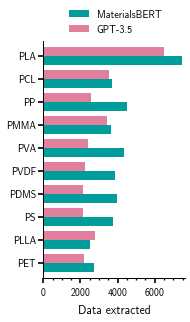

In [85]:
plt.rcParams['font.family'] = 'cursive'
colors = ["#009d9a", "#e0809d"]

voffset = 0.0

fig, ax = plt.subplots(1, 1, figsize=(1.7, 2.8), dpi=120, sharex=True)
barprops = dict(color=colors, align='center', width=0.8, bottom=voffset)

df = top[['bert', 'gpt']]
df = df.iloc[::-1]

df.plot.barh(ax=ax, **barprops)

ax.set(ylabel='', xlabel='Data extracted')
ax.tick_params(axis='y', which='minor', left=False)
ax.legend(['MaterialsBERT', 'GPT-3.5'], loc=(0.15, 1.01), ncol=1, fontsize=6)
# ax.set_xticks(ax.get_xticks(), metrics.index, rotation=90, ha='right')

plt.tight_layout()
plt.savefig("notebooks/top10-polymers-bars.png", dpi=600)
plt.show()

## Venn Diagrams

In [ ]:
def plot_venn_diagram(A, B, label_a, label_b, title="", saveas=None):
    A = set(A)
    B = set(B)
    a_not_b = len(A - B)
    b_not_a = len(B - A)
    a_and_b = len(A & B)
    total = a_not_b + b_not_a + a_and_b

    fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.8))
    v = venn2(subsets=(a_not_b, b_not_a, a_and_b), ax=ax)
    for p in v.patches:
        p.set_linewidth(1)
        p.set_edgecolor('k')

    v.get_label_by_id('10').set_text(f"{100 * a_not_b / total : 0.2f}%")
    v.get_label_by_id('01').set_text(f"{100 * b_not_a / total : 0.2f}%")
    v.get_label_by_id('11').set_text(f"{100 * a_and_b / total : 0.2f}%")
    title += f"\nTotal: {total :,}"
    print(title)
    # ax.set(title = title)
    plt.tight_layout()
    if saveas:
        plt.savefig(saveas, dpi=300)
    plt.show()

## Paragraphs

In [63]:
# Create a set of all paragraphs where GPT extracted data
gpt_paras = []

# props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")
# props = [p.property for p in props]
props = ['tg', 'bandgap']

for prop in props:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT em.para_id as id
    FROM extracted_data ed 
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ed."method" = 'GPT-3.5' AND ed.property = :prop;
    """, prop=prop)
    for r in rows:
        gpt_paras.append(r.id)

print("\nGPT Done. Total paras =", len(gpt_paras))

tg bandgap 
Done. Total paras = 188946


In [67]:
# Create a set of all paragraphs where MaterialsBERT extracted data
mtb_paras = []

# props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")
# props = [p.property for p in props]
props = ['tg', 'bandgap']

for prop in props:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT em.para_id as id FROM extracted_data ed 
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ed."method" = 'MaterialsBERT' AND ed.property = :prop
    AND EXISTS (
        SELECT fp.para_id FROM filtered_paragraphs fp 
        WHERE fp.filter_name LIKE '%_ner_full'
        AND fp.para_id = em.para_id
    );
    """, prop=prop)
    for r in rows:
        mtb_paras.append(r.id)

print("\nMBT Done. Total paras =", len(mtb_paras))

tg bandgap 
MBT Done. Total paras = 87545


Combined Total Number of Paragraphs
Total: 102,427
Exclusive to MBT: 7311
Exclusive to GPT: 47966
Extracted by Both: 47150


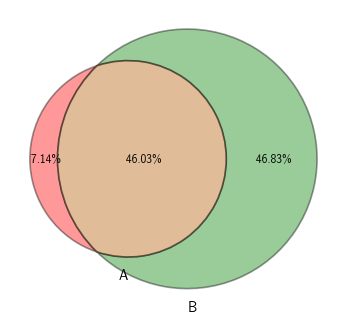

In [68]:
title="Combined Total Number of Unique Paragraphs"
saveas = "notebooks/venn_paragraphs.svg"

A = set(mtb_paras)
B = set(gpt_paras)

a_not_b = len(A - B)
b_not_a = len(B - A)
a_and_b = len(A & B)
total = a_not_b + b_not_a + a_and_b

fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.8))
v = venn2(subsets=(a_not_b, b_not_a, a_and_b), ax=ax)
for p in v.patches:
    p.set_linewidth(1)
    p.set_edgecolor('k')

# v.get_label_by_id('10').set_text(f"{a_not_b:,}")
# v.get_label_by_id('01').set_text(f"{b_not_a:,}")
# v.get_label_by_id('11').set_text(f"{a_and_b:,}")

v.get_label_by_id('10').set_text(f"{100 * a_not_b / total : 0.2f}%")
v.get_label_by_id('01').set_text(f"{100 * b_not_a / total : 0.2f}%")
v.get_label_by_id('11').set_text(f"{100 * a_and_b / total : 0.2f}%")


title += f"\nTotal: {total :,}"
print(title)
print("Exclusive to MBT:", a_not_b)
print("Exclusive to GPT:", b_not_a)
print("Extracted by Both:", a_and_b)

# ax.set(title = title)
plt.tight_layout()
if saveas:
    plt.savefig(saveas, dpi=300)
plt.show()

## Materials

In [72]:
# Create a set of all paragraphs where GPT extracted data
gpt_mats = []

# props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")
# props = [p.property for p in props]
props = ['tg', 'bandgap']

for prop in props:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT ed.material
    FROM extracted_data ed 
    WHERE ed."method" = 'GPT-3.5' AND ed.property = :prop;
    """, prop=prop)
    for r in rows:
        gpt_mats.append(r.material)

print("\nGPT Done. Total materials =", len(gpt_mats))

tg bandgap 
Done. Total materials = 188946


In [73]:
# Create a set of all paragraphs where MaterialsBERT extracted data
mtb_mats = []

# props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")
# props = [p.property for p in props]
props = ['tg', 'bandgap']

for prop in props:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT ed.material FROM extracted_data ed 
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ed."method" = 'MaterialsBERT' AND ed.property = :prop
    AND EXISTS (
        SELECT fp.para_id FROM filtered_paragraphs fp 
        WHERE fp.filter_name LIKE '%_ner_full'
        AND fp.para_id = em.para_id
    );
    """, prop=prop)
    for r in rows:
        mtb_mats.append(r.material)

print("\nMBT Done. Total materials =", len(mtb_mats))

tg bandgap 
MBT Done. Total materials = 87545


Combined Total Number of Unique Materials
Total: 113,099
Exclusive to MBT: 13929
Exclusive to GPT: 88128
Extracted by Both: 11042


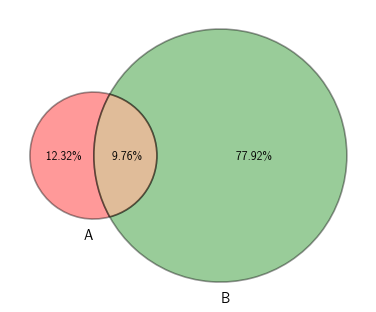

In [74]:
title="Combined Total Number of Unique Materials"
saveas = "notebooks/venn_materials.svg"

A = set(mtb_mats)
B = set(gpt_mats)

a_not_b = len(A - B)
b_not_a = len(B - A)
a_and_b = len(A & B)
total = a_not_b + b_not_a + a_and_b

fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.8))
v = venn2(subsets=(a_not_b, b_not_a, a_and_b), ax=ax)
for p in v.patches:
    p.set_linewidth(1)
    p.set_edgecolor('k')

v.get_label_by_id('10').set_text(f"{a_not_b:,}")
v.get_label_by_id('01').set_text(f"{b_not_a:,}")
v.get_label_by_id('11').set_text(f"{a_and_b:,}")

v.get_label_by_id('10').set_text(f"{100 * a_not_b / total : 0.2f}%")
v.get_label_by_id('01').set_text(f"{100 * b_not_a / total : 0.2f}%")
v.get_label_by_id('11').set_text(f"{100 * a_and_b / total : 0.2f}%")

title += f"\nTotal: {total :,}"
print(title)
print("Exclusive to MBT:", a_not_b)
print("Exclusive to GPT:", b_not_a)
print("Extracted by Both:", a_and_b)

# ax.set(title = title)
plt.tight_layout()
if saveas:
    plt.savefig(saveas, dpi=600)
plt.show()

## Missed Paragraphs

In [69]:
propname = 'bandgap'

mbt_not_gpt = postgres.raw_sql("""
SELECT em.para_id FROM extracted_data ed 
JOIN extracted_properties ep ON ep.id = ed.property_id 
JOIN extracted_materials em ON em.id = ep.material_id
WHERE ed."method" = 'MaterialsBERT'
AND ed.property = :prop
AND NOT EXISTS (
	SELECT em2.para_id FROM extracted_data ed2
	JOIN extracted_properties ep2 ON ep2.id = ed2.property_id 
	JOIN extracted_materials em2 ON em2.id = ep2.material_id
	WHERE ed2."method" = 'GPT-3.5'
	AND ed2.property = :prop
	AND em2.para_id = em.para_id 
)
AND EXISTS (
	SELECT fp.para_id FROM filtered_paragraphs fp 
	WHERE fp.filter_name LIKE '%_ner_full'
	AND fp.para_id = em.para_id
);
""", prop = propname)
print("Extracted by MBT but not by GPT: Number of source paragraphs =", len(set([m.para_id for m in mbt_not_gpt])))

Extracted by MBT but not by GPT: Number of source paragraphs = 1537


In [70]:
not_sent_to_api = postgres.raw_sql("""
SELECT em.para_id FROM extracted_data ed 
JOIN extracted_properties ep ON ep.id = ed.property_id 
JOIN extracted_materials em ON em.id = ep.material_id
WHERE ed."method" = 'MaterialsBERT'
AND ed.property = :prop
AND NOT EXISTS (
	SELECT em2.para_id FROM extracted_data ed2
	JOIN extracted_properties ep2 ON ep2.id = ed2.property_id 
	JOIN extracted_materials em2 ON em2.id = ep2.material_id
	WHERE ed2."method" = 'GPT-3.5'
	AND ed2.property = :prop
	AND em2.para_id = em.para_id 
)
AND EXISTS (
	SELECT fp.para_id FROM filtered_paragraphs fp 
	WHERE fp.filter_name LIKE '%_ner_full'
	AND fp.para_id = em.para_id
)
AND NOT EXISTS (
	SELECT * FROM api_requests ar 
	WHERE ar.api = 'openai'
	AND ar.para_id = em.para_id 
);
""", prop = propname)
print("Paragraphs not sent to OpenAI =", len(set([m.para_id for m in not_sent_to_api])))

Paragraphs not sent to OpenAI = 88


In [71]:
sent_to_api = postgres.raw_sql("""
SELECT em.para_id FROM extracted_data ed 
JOIN extracted_properties ep ON ep.id = ed.property_id 
JOIN extracted_materials em ON em.id = ep.material_id
WHERE ed."method" = 'MaterialsBERT'
AND ed.property = :prop
AND NOT EXISTS (
	SELECT em2.para_id FROM extracted_data ed2
	JOIN extracted_properties ep2 ON ep2.id = ed2.property_id 
	JOIN extracted_materials em2 ON em2.id = ep2.material_id
	WHERE ed2."method" = 'GPT-3.5'
	AND ed2.property = :prop
	AND em2.para_id = em.para_id 
)
AND EXISTS (
	SELECT fp.para_id FROM filtered_paragraphs fp 
	WHERE fp.filter_name LIKE '%_ner_full'
	AND fp.para_id = em.para_id
)
AND EXISTS (
	SELECT * FROM api_requests ar 
	WHERE ar.api = 'openai'
	AND ar.para_id = em.para_id 
);
""", prop = propname)
print("Paragraphs sent to OpenAI =", len(set([m.para_id for m in sent_to_api])))

Paragraphs sent to OpenAI = 1449


Paragraphs not sent to GPT: 11208
Paragraphs sent to GPT: 6749


## Pairwise Plots

In [ ]:
def plot_jitter_pair(material, prop1, prop2, n = 100):
    gpt1 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'GPT-3.5', prop = prop1)
    
    gpt2 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'GPT-3.5', prop = prop2)

    mbt1 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'MaterialsBERT', prop = prop1)
    
    mbt2 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'MaterialsBERT', prop = prop2)

    m1 = min(mbt1.shape[0], mbt2.shape[0])
    m2 = min(gpt1.shape[0], gpt2.shape[0])

    fig, ax = plt.subplots(1, 1, figsize=(4.25, 2.0))

    if m1 > 0:
        ax.plot(
            [mbt1.sample().value.iloc[0] for _ in range(n)],
            [mbt2.sample().value.iloc[0] for _ in range(n)],
            'x', color="#009d9a", label = 'MaterialsBERT')

    if m2 > 0:
        ax.plot(
            [gpt1.sample().value.iloc[0] for _ in range(n)],
            [gpt2.sample().value.iloc[0] for _ in range(n)],
            '.', color="#e0809d", label = 'GPT-3.5')

    ax.set(xlabel=prop1, ylabel=prop2, title=material)
    ax.legend(loc=(1.01, 0.4))
    plt.tight_layout()
    plt.show()

In [ ]:
props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")
props = [p.property for p in props]

for prop1 in props:
    for prop2 in props:
        if prop1 == prop2:
            continue

        print(prop2, 'vs.', prop1)
        plot_jitter_pair(material, prop1, prop2, n)

